In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import seaborn as sns
import cmcrameri.cm as cmc

In [2]:
filename = "/mnt/data-storage/yaguangli2023/stellar-models/grid_models_surface_effect_uncorrected/grid.h5"
tracks = pd.read_hdf(filename, "tracks")
tracks.head()

star_mass     Yinit     Zinit      amlt  fov_core  fov_shell
track                                                              
7000     0.92329  0.279311  0.001829  1.608258  0.000000   0.006041
7001     1.72329  0.229311  0.010871  2.308258  0.012396   0.006041
7002     2.12329  0.304311  0.004172  2.658258  0.015861   0.006041
7003     1.32329  0.254311  0.024469  1.958258  0.002481   0.006041
7004     1.12329  0.291811  0.006519  2.133258  0.000000   0.006041

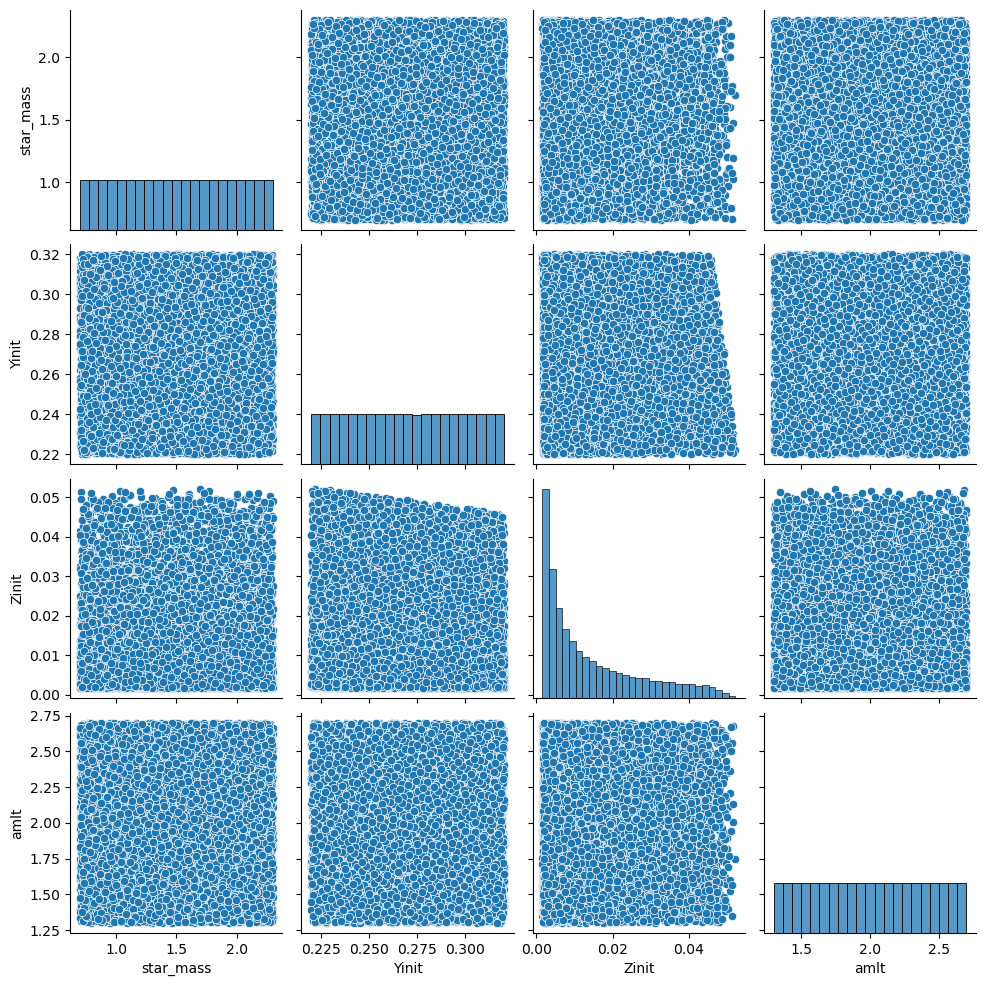

In [3]:
vars = ["star_mass", "Yinit", "Zinit", "amlt"]
sns.pairplot(tracks, vars=vars);

In [4]:
stars = pd.read_hdf(filename, "stars")
stars.head()

star_age    radius         Teff  center_h1    log_LHe  \
track star                                                              
7000  1     2.220454e+07  0.893151  6382.509287   0.718192 -45.291905   
      2     2.300916e+07  0.891027  6377.312552   0.718122 -45.308912   
      3     2.397470e+07  0.890320  6373.785487   0.718037 -45.328570   
      4     3.019433e+07  0.893682  6371.412400   0.717474 -45.392646   
      5     3.259691e+07  0.894573  6371.453759   0.717253 -45.402736   

            log_Lnuc  Dnu_freq_o     eps_o  
track star                                  
7000  1     0.078416  148.565794  1.129515  
      2     0.077135  149.148739  1.131800  
      3     0.075916  149.362908  1.132830  
      4     0.075178  148.552167  1.130613  
      5     0.075810  148.331713  1.129892

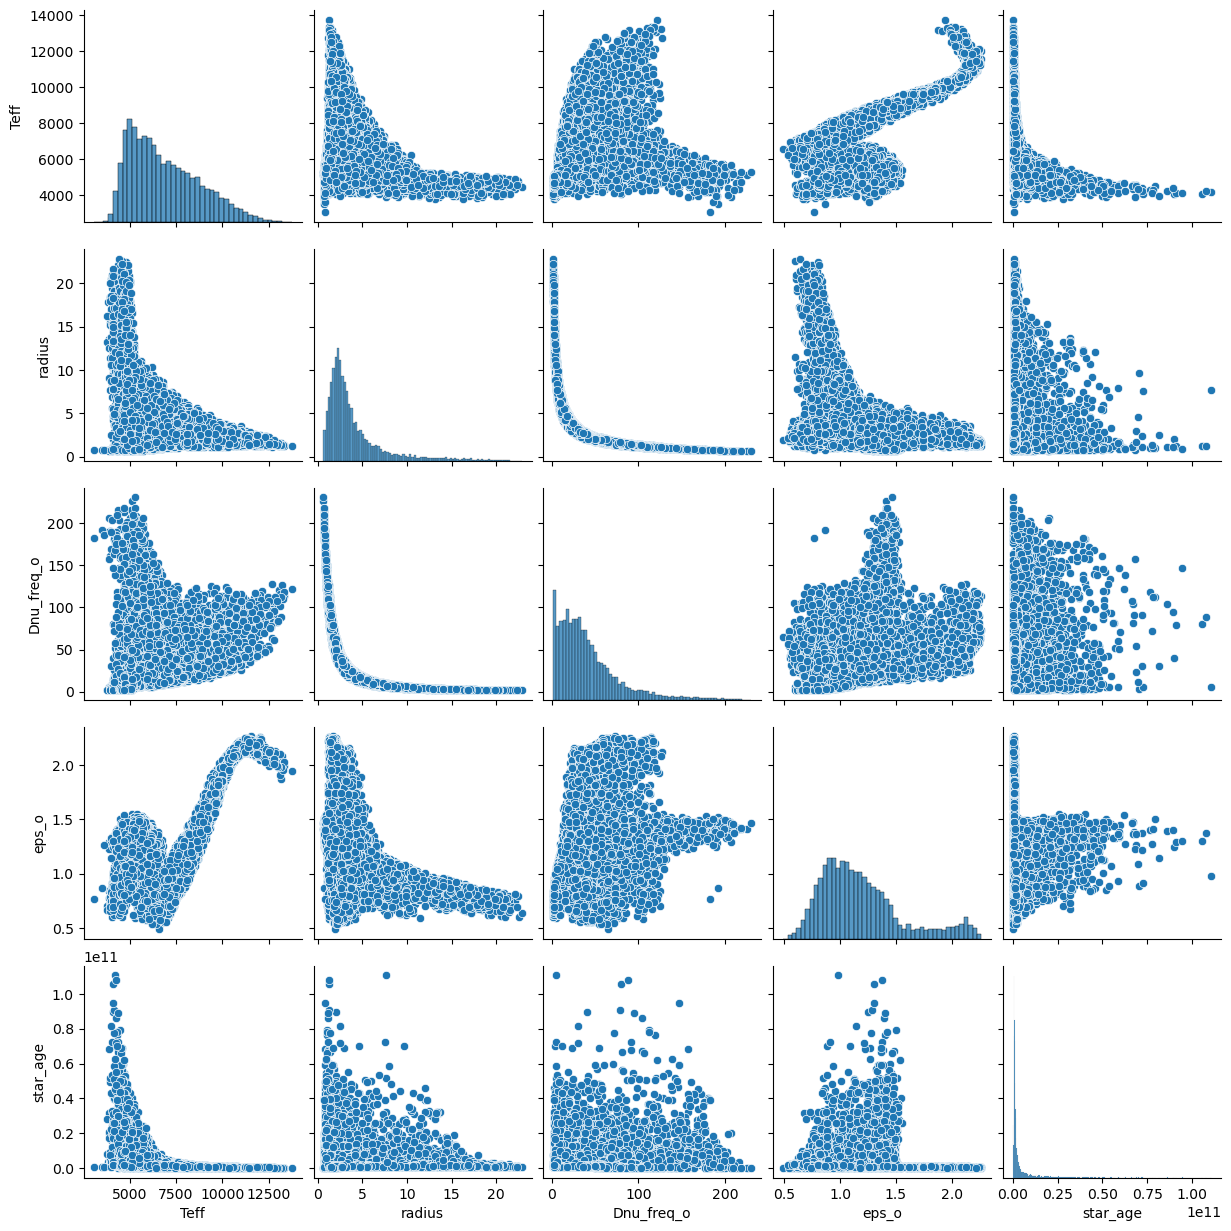

In [5]:
num_samples = 10000
vars = ["Teff", "radius", "Dnu_freq_o", "eps_o", "star_age"]
sns.pairplot(stars.sample(num_samples), vars=vars);

In [6]:
mask = (stars.star_age < 2e10)
grid = tracks.join(stars.loc[mask]).reset_index()

In [7]:
grid.head()

track  star  star_mass     Yinit     Zinit      amlt  fov_core  fov_shell  \
0   7000     1    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   
1   7000     2    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   
2   7000     3    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   
3   7000     4    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   
4   7000     5    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   

       star_age    radius         Teff  center_h1    log_LHe  log_Lnuc  \
0  2.220454e+07  0.893151  6382.509287   0.718192 -45.291905  0.078416   
1  2.300916e+07  0.891027  6377.312552   0.718122 -45.308912  0.077135   
2  2.397470e+07  0.890320  6373.785487   0.718037 -45.328570  0.075916   
3  3.019433e+07  0.893682  6371.412400   0.717474 -45.392646  0.075178   
4  3.259691e+07  0.894573  6371.453759   0.717253 -45.402736  0.075810   

   Dnu_freq_o     eps_o  
0  148.565794  1.129515  
1  149.148739  1.131800  
2  149.362908  1.132830  
3  148.552167  1.130613  
4  148.331713  1.129892

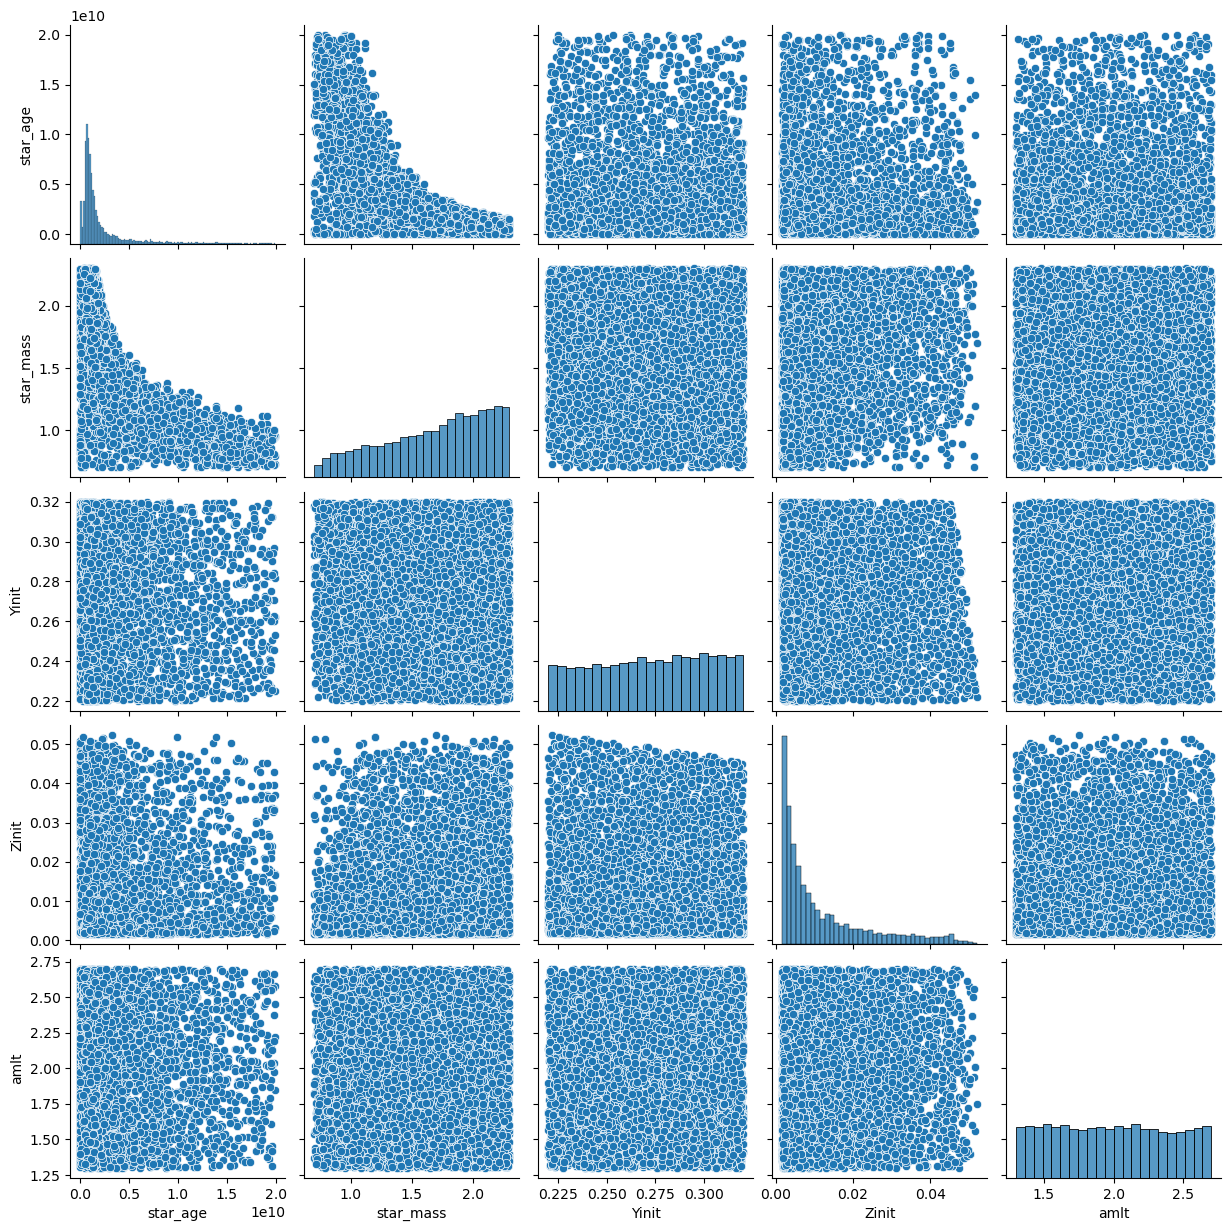

In [8]:
num_samples = 10000
vars = ["star_age", "star_mass", "Yinit", "Zinit", "amlt"]
sns.pairplot(grid.sample(num_samples), vars=vars);

In [9]:
grid["log_Zinit"] = np.log10(grid.Zinit)
grid["log_age"] = np.log10(grid.star_age)

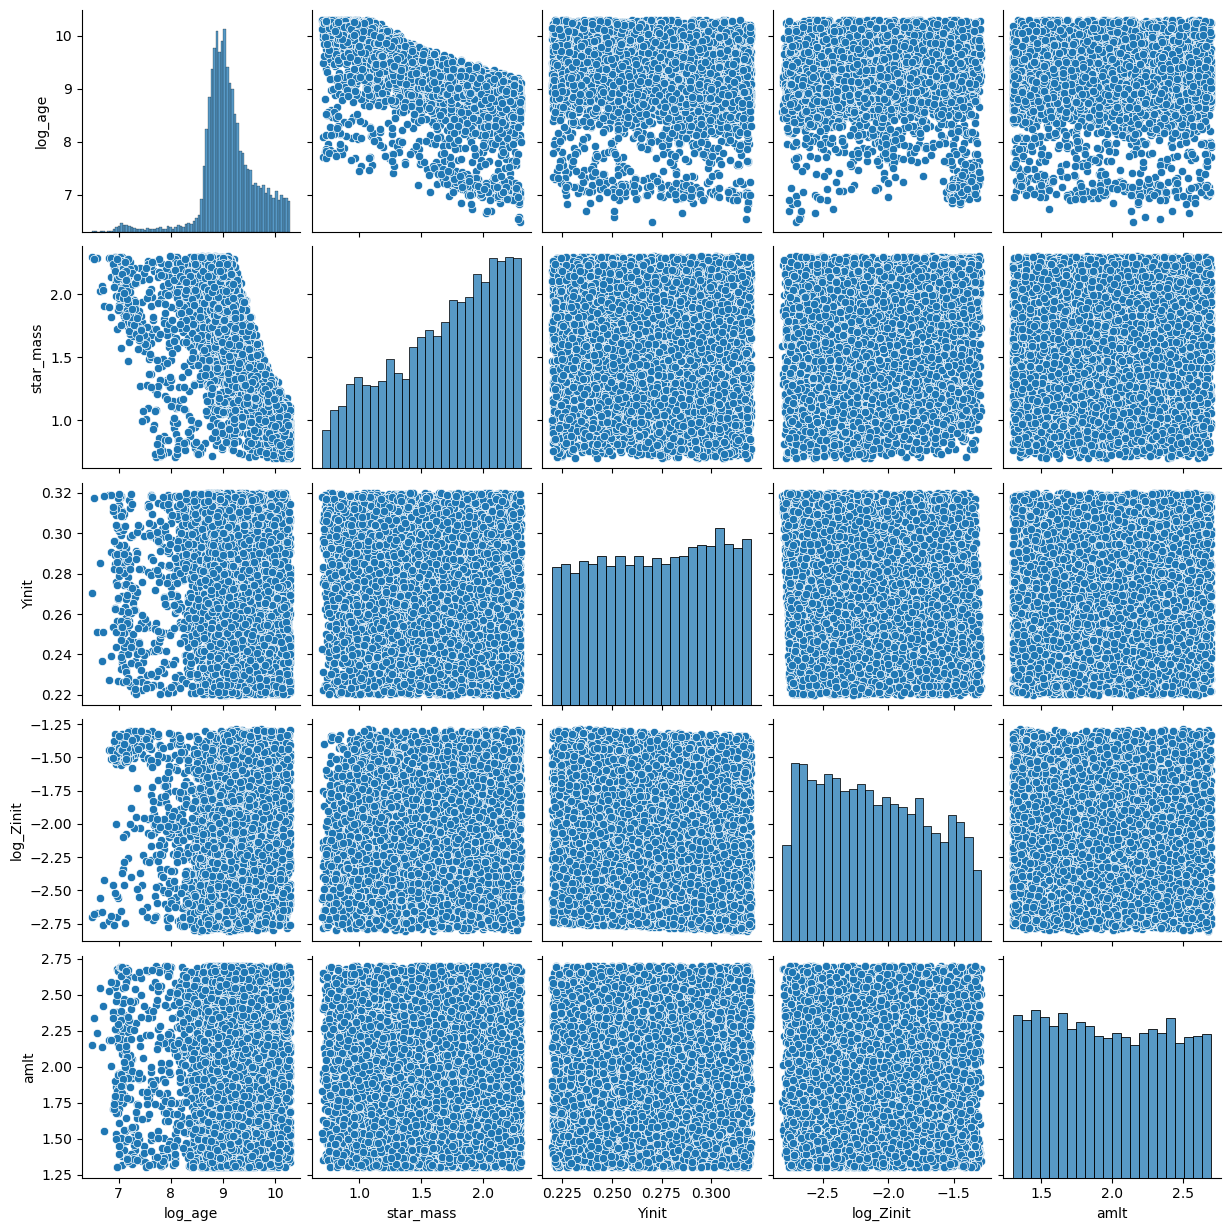

In [10]:
vars = ["log_age", "star_mass", "Yinit", "log_Zinit", "amlt"]
sns.pairplot(grid.sample(num_samples), vars=vars);

What is the young age overdensity?

In [11]:
solar_teff = 5772.0034291
grid["L"] = grid["radius"]**2 * (grid["Teff"]/solar_teff)**4

In [12]:
grid["Lnuc"] = 10**grid["log_Lnuc"]

In [13]:
grid["f_nuc"] = grid["Lnuc"]/grid["L"]

In [14]:
grid["Xinit"] = 1 - grid.Yinit - grid.Zinit

In [15]:
grid["delta_X"] = grid["Xinit"] - grid.center_h1

## To Do

- Go through each track, condition delta_X > 0.0015
- Then choose first point where Lnuc/L > 0.999

In [23]:
idxs = []
for idx, group in grid.groupby("track"):
    hburn = (group["f_nuc"] > 0.999) & (group["delta_X"] > 0.0015)
    mask = group.index < hburn.idxmax()
    idxs.append(group.index[mask].to_numpy())
#     mask.idxmax()
    # TODO: cut the points before this for each group

In [26]:
grid_clean = grid.drop(index=np.concatenate(idxs))

Text(0, 0.5, 'L (Lsun)')

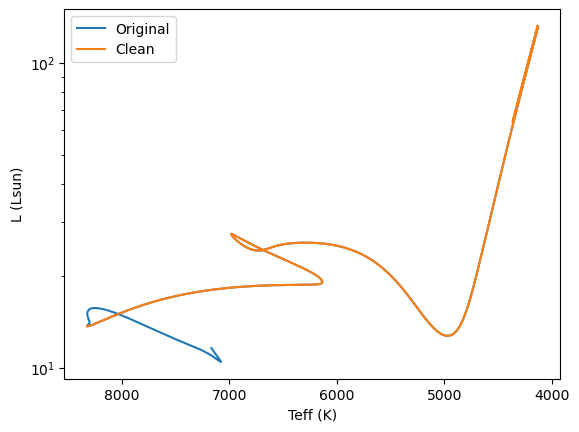

In [41]:
t = 13
ax = grid.loc[grid.track == t].plot(x="Teff", y="L", c="C0", label="Original")
ax = grid_clean.loc[grid_clean.track == t].plot(x="Teff", y="L", c="C1", ax=ax, label="Clean")

ax.invert_xaxis()
ax.set_yscale("log")
ax.set_xlabel("Teff (K)")
ax.set_ylabel("L (Lsun)")

Text(0, 0.5, 'L (Lsun)')

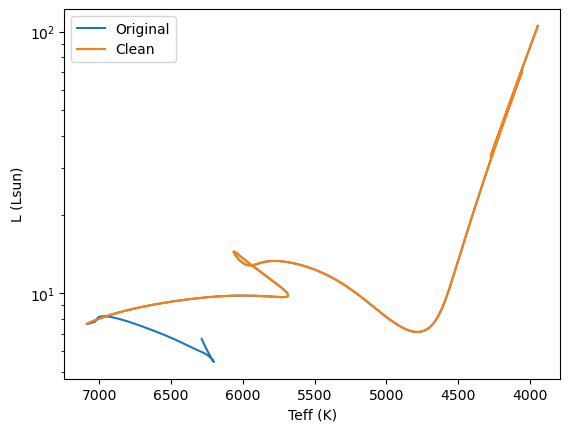

In [42]:
t = 2813
ax = grid.loc[grid.track == t].plot(x="Teff", y="L", c="C0", label="Original")
ax = grid_clean.loc[grid_clean.track == t].plot(x="Teff", y="L", c="C1", ax=ax, label="Clean")

ax.invert_xaxis()
ax.set_yscale("log")
ax.set_xlabel("Teff (K)")
ax.set_ylabel("L (Lsun)")

Nice! That now avoids the little bit of nuclear burning on the pre-MS.

In [99]:
ts = grid_clean.track.sample(100)
mask = grid.track.isin(ts)

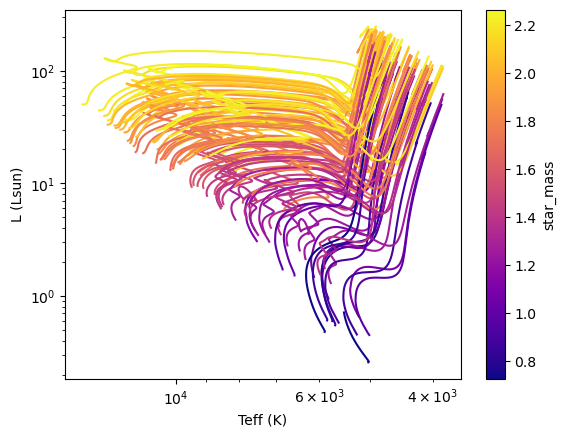

In [146]:
fig, ax = plt.subplots()
# cmap = cmc.batlow
cmap = cm.plasma
colorby = "star_mass"

vmin, vmax = grid_clean.loc[mask, colorby].min(), grid_clean.loc[mask, colorby].max()
norm = Normalize(vmin=vmin, vmax=vmax)

for idx, group in grid_clean.loc[mask].groupby("track", sort=False):
    label = None
    c = cmap(
        norm(group[colorby].iloc[0])
    )
    ax = group.plot(x="Teff", y="L", c=c, ax=ax, label=label)

ax.invert_xaxis()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Teff (K)")
ax.set_ylabel("L (Lsun)")
# ax.legend(title="M, Yinit, Zinit, amlt")
ax.get_legend().remove()

mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(mappable, ax=ax, label=colorby)

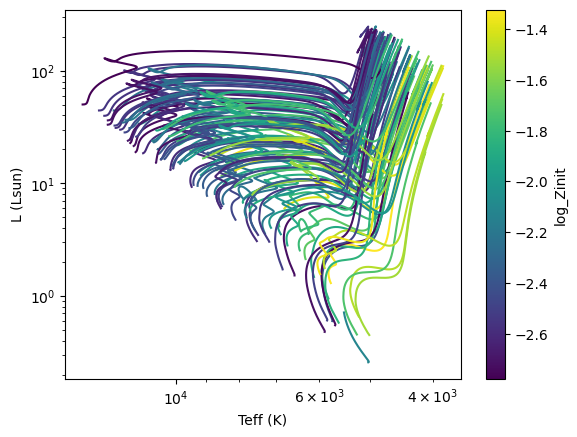

In [145]:
fig, ax = plt.subplots()
# cmap = cmc.hawaii
cmap = cm.viridis
colorby = "log_Zinit"

vmin, vmax = grid_clean.loc[mask, colorby].min(), grid_clean.loc[mask, colorby].max()
norm = Normalize(vmin=vmin, vmax=vmax)

for idx, group in grid_clean.loc[mask].groupby("track", sort=False):
    label = None
    c = cmap(
        norm(group[colorby].iloc[0])
    )
    ax = group.plot(x="Teff", y="L", c=c, ax=ax, label=label)

ax.invert_xaxis()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Teff (K)")
ax.set_ylabel("L (Lsun)")
# ax.legend(title="M, Yinit, Zinit, amlt")
ax.get_legend().remove()

mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(mappable, ax=ax, label=colorby)

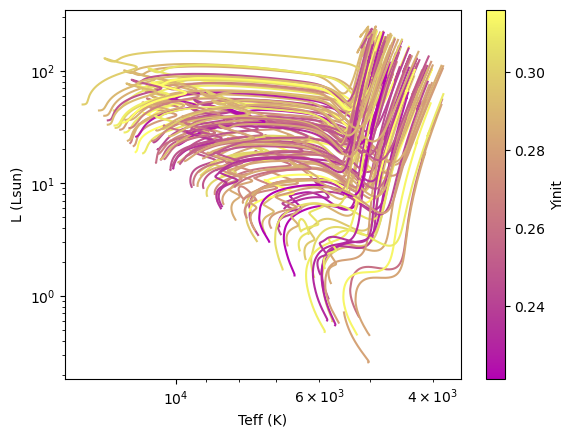

In [147]:
fig, ax = plt.subplots()
# cmap = cmc.buda
cmap = cmc.buda
colorby = "Yinit"

vmin, vmax = grid_clean.loc[mask, colorby].min(), grid_clean.loc[mask, colorby].max()
norm = Normalize(vmin=vmin, vmax=vmax)

for idx, group in grid_clean.loc[mask].groupby("track", sort=False):
    label = None
    c = cmap(
        norm(group[colorby].iloc[0])
    )
    ax = group.plot(x="Teff", y="L", c=c, ax=ax, label=label)

ax.invert_xaxis()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Teff (K)")
ax.set_ylabel("L (Lsun)")
# ax.legend(title="M, Yinit, Zinit, amlt")
ax.get_legend().remove()

mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(mappable, ax=ax, label=colorby)

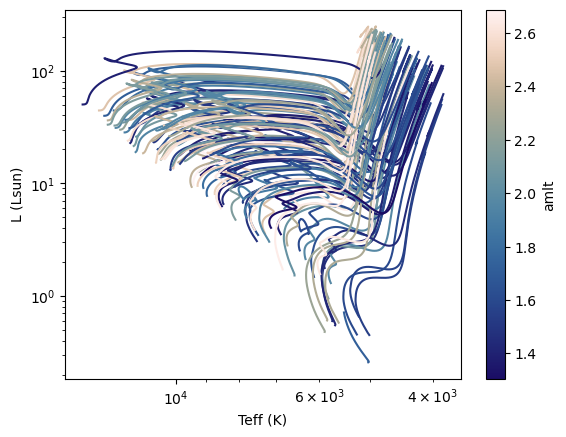

In [148]:
fig, ax = plt.subplots()
cmap = cmc.lapaz
colorby = "amlt"

vmin, vmax = grid_clean.loc[mask, colorby].min(), grid_clean.loc[mask, colorby].max()
norm = Normalize(vmin=vmin, vmax=vmax)

for idx, group in grid_clean.loc[mask].groupby("track", sort=False):
    label = None
    c = cmap(
        norm(group[colorby].iloc[0])
    )
    ax = group.plot(x="Teff", y="L", c=c, ax=ax, label=label)

ax.invert_xaxis()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Teff (K)")
ax.set_ylabel("L (Lsun)")
# ax.legend(title="M, Yinit, Zinit, amlt")
ax.get_legend().remove()

mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(mappable, ax=ax, label=colorby)

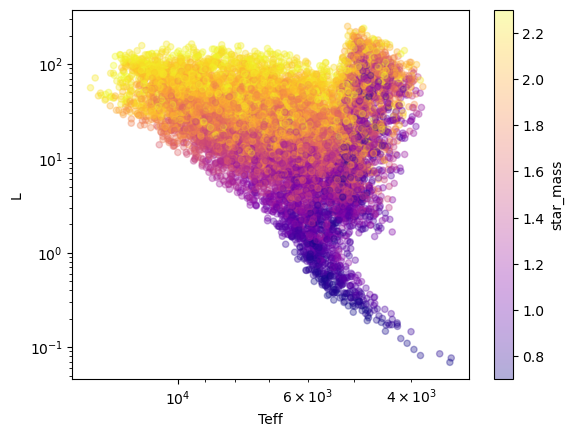

In [142]:
ax = grid_clean.sample(num_samples).plot(x="Teff", y="L", c="star_mass", cmap=cm.plasma, kind="scatter", alpha=0.33)
ax.set_xscale("log")
ax.set_yscale("log")
ax.invert_xaxis()

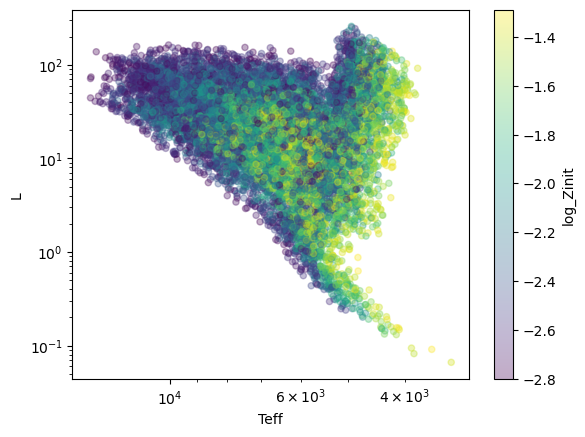

In [143]:
ax = grid_clean.sample(num_samples).plot(x="Teff", y="L", c="log_Zinit", cmap=cm.viridis, kind="scatter", alpha=0.33)
ax.set_xscale("log")
ax.set_yscale("log")
ax.invert_xaxis()

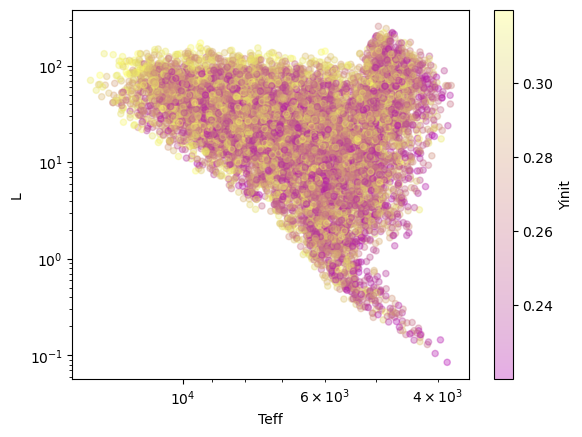

In [144]:
ax = grid_clean.sample(num_samples).plot(x="Teff", y="L", c="Yinit", cmap=cmc.buda, kind="scatter", alpha=0.33)
ax.set_xscale("log")
ax.set_yscale("log")
ax.invert_xaxis()

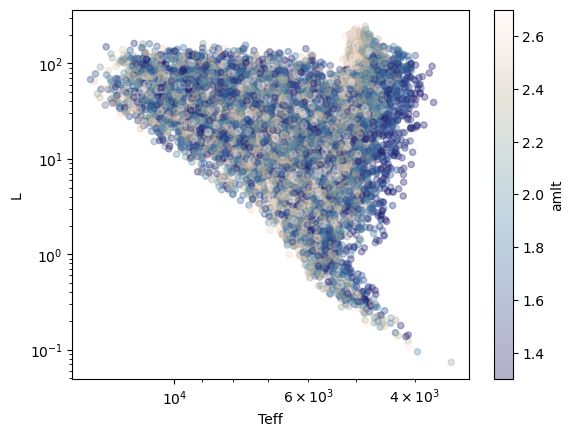

In [141]:
ax = grid_clean.sample(num_samples).plot(x="Teff", y="L", c="amlt", cmap=cmc.lapaz, kind="scatter", alpha=0.33)
ax.set_xscale("log")
ax.set_yscale("log")
ax.invert_xaxis()

In [164]:
meta = pd.Series({
    "msun": 1.9884098706980504e33,
    "rsun": 6.957e10,
    "lsun": 3.8280000000000003e33,
    "Tsun": 5772.0034291,
})
meta

msun    1.988410e+33
rsun    6.957000e+10
lsun    3.828000e+33
Tsun    5.772003e+03
dtype: float64

In [165]:
meta.to_hdf(filename, "constants", format="table")

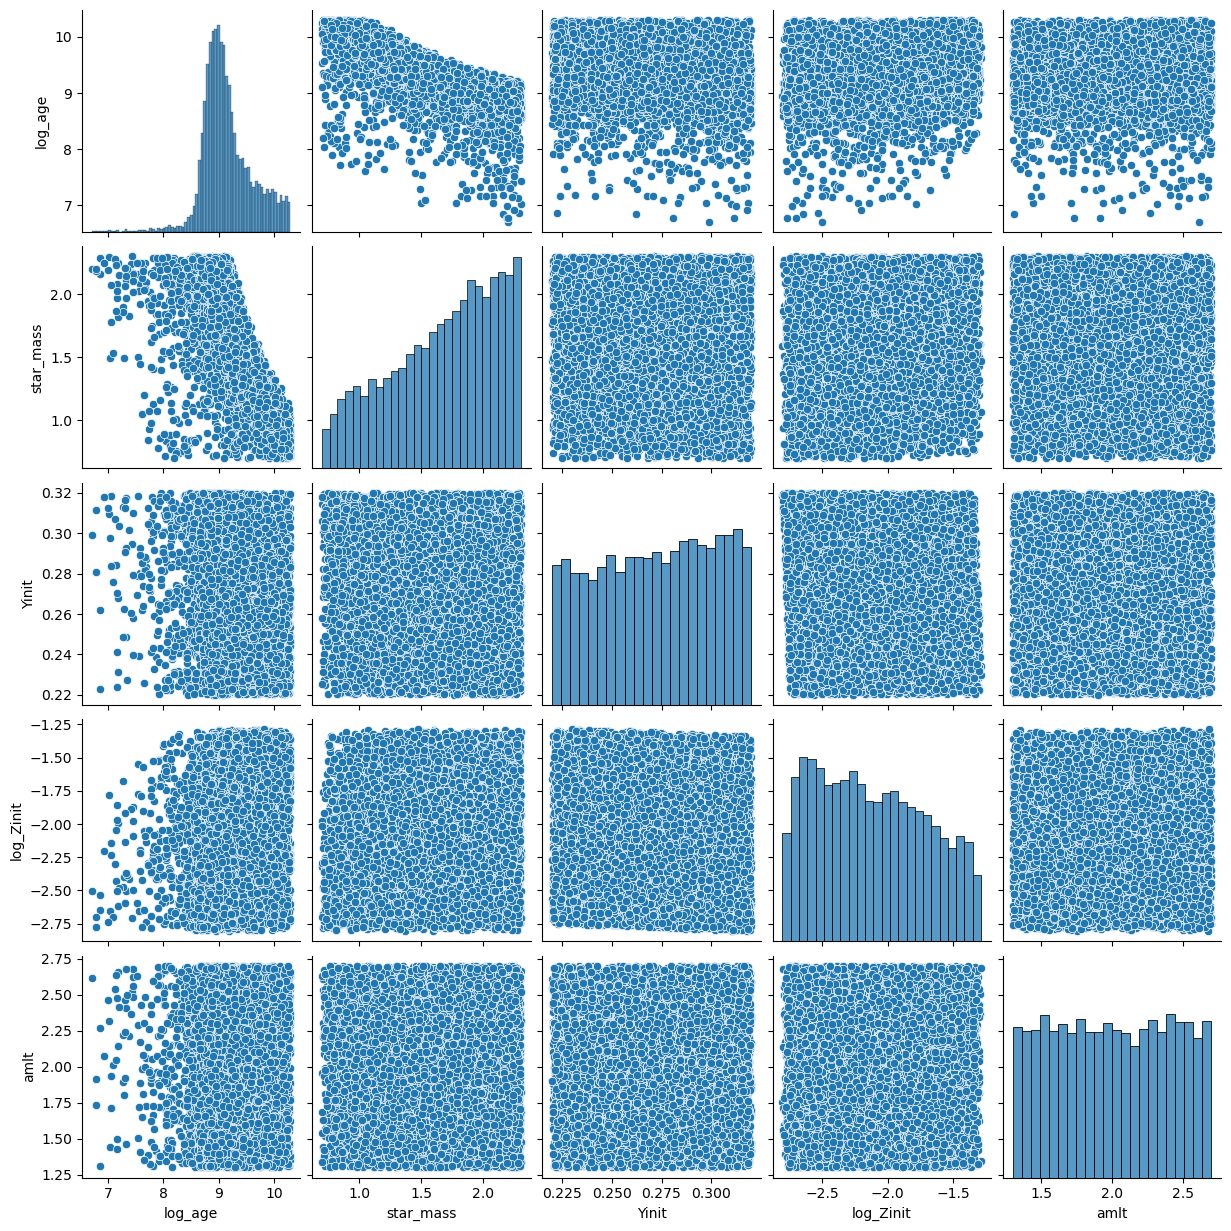

In [166]:
vars = ["log_age", "star_mass", "Yinit", "log_Zinit", "amlt"]
sns.pairplot(grid_clean.sample(num_samples), vars=vars);

Modify Beta parameters in Adam to be very close to 1.

BP - RP cut for.